In [37]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [38]:
#Data import and a little cleaning
df = pd.read_csv(r"C:\Users\brand\OneDrive\Documents\Bootcamp Projects\Capstone Project 2\Cleaned Data\Csv_CD.csv").drop('Unnamed: 0',axis=1)
df2 = df.drop(['Name','Publisher','NA_Sales','EU_Sales','JP_Sales','Other_Sales','Developer','Year_of_Release'], axis=1)

In [39]:
# getting initial dataframe info
print(df2.describe())
print('-'*80)
print("Dataframe shape:\n",df2.shape)
print('-'*80)
df2.info()
print('-'*80)
print('Null value counts:\n',df2.isnull().sum())
print('-'*80)
print('Feature dtypes:\n', df2.dtypes)

       Global_Sales  Critic_Score  Critic_Count   User_Score    User_Count
count   1688.000000   1688.000000   1688.000000  1688.000000   1688.000000
mean       1.898199     75.927725     42.361967     7.568246    325.350118
std        3.577727     11.476560     22.170379     1.132517    738.857794
min        0.040000     33.000000      4.000000     1.700000      4.000000
25%        0.410000     69.000000     25.000000     7.000000     36.000000
50%        0.910000     77.000000     40.000000     7.800000     87.000000
75%        2.040000     84.000000     57.250000     8.400000    263.000000
max       82.530000     98.000000    113.000000     9.600000  10179.000000
--------------------------------------------------------------------------------
Dataframe shape:
 (1688, 8)
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 8 columns):
 #   Column        Non-Null C

{'whiskers': [<matplotlib.lines.Line2D at 0x294a4b63890>,
 'caps': [<matplotlib.lines.Line2D at 0x294a4b0c950>,
 'boxes': [<matplotlib.lines.Line2D at 0x294a4b62f50>],
 'medians': [<matplotlib.lines.Line2D at 0x294a4b0dc90>],
 'fliers': [<matplotlib.lines.Line2D at 0x294a4b0d950>],
 'means': []}

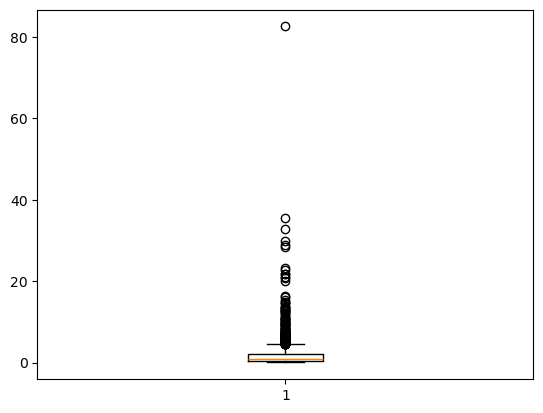

In [40]:
# Global Sales has some outliers
plt.boxplot(df2['Global_Sales'])

Valid records left:
 (1270,)
count    1270.000000
mean        1.068323
std         0.750900
min         0.210000
25%         0.470000
50%         0.850000
75%         1.490000
max         3.180000
Name: Global_Sales, dtype: float64


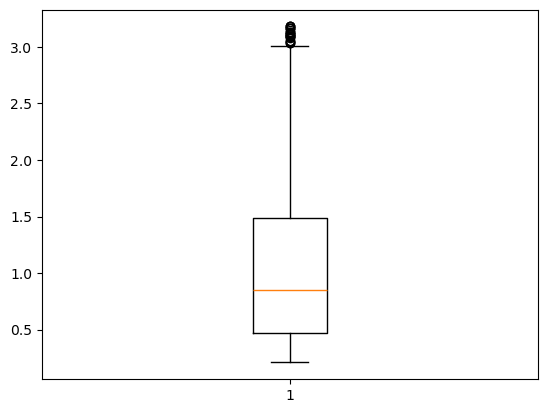

In [41]:
# filtering for lower 10% and  higher 85% quantiles of Global Sales. Settled here because it left me enough data and filterd most of the extreme outliers.
# Should help with model trainig.
l_quant = df['Global_Sales'].quantile(0.10)
h_quant = df['Global_Sales'].quantile(0.85)
df2_filtered = df2[(df2['Global_Sales'] >= l_quant) & (df2['Global_Sales'] <= h_quant)]

plt.boxplot(df2_filtered['Global_Sales'])
print('Valid records left:\n',df2_filtered['Global_Sales'].shape)
print(df2_filtered['Global_Sales'].describe())


In [42]:
# getting dummies
df3 = pd.get_dummies(df2_filtered, columns=['Rating','Genre','Platform'])
df3.head()

,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating_E,Rating_E10+,Rating_K-A,Rating_M,Rating_T,...,Platform_PS2,Platform_PS3,Platform_PS4,Platform_PSP,Platform_PSV,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne
254,3.18,91,79,8.6,565,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
255,3.18,62,30,8.1,137,False,False,False,False,True,...,True,False,False,False,False,False,False,False,False,False
256,3.18,83,67,8.0,463,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
257,3.17,82,63,7.6,85,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
258,3.17,89,78,7.7,1010,False,False,False,True,False,...,False,True,False,False,False,False,False,False,False,False


In [43]:
#Setting features and target variable for model
X = df3.drop(['Global_Sales'],axis=1)
y= df3['Global_Sales']

#slpitting data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [44]:
#Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Reshape input for LSTM [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [45]:
#model

model = Sequential()
# Adding LSTM layer
model.add(LSTM(units=1000, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dropout(0.2))
# Adding another LSTM layer
model.add(LSTM(units=1000, return_sequences=False))
model.add(Dropout(0.2))
# Output layer
model.add(Dense(units=1))  # Predicting sales (continuous value)
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model and store training history
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test))

Epoch 1/100
28/28 [==============================] - 4s 50ms/step - loss: 1.0180 - val_loss: 0.5324
Epoch 2/100
28/28 [==============================] - 1s 29ms/step - loss: 0.5025 - val_loss: 0.5307
Epoch 3/100
28/28 [==============================] - 1s 29ms/step - loss: 0.4252 - val_loss: 0.4752
Epoch 4/100
28/28 [==============================] - 1s 30ms/step - loss: 0.3975 - val_loss: 0.4395
Epoch 5/100
28/28 [==============================] - 1s 29ms/step - loss: 0.4010 - val_loss: 0.4478
Epoch 6/100
28/28 [==============================] - 1s 29ms/step - loss: 0.3691 - val_loss: 0.4248
Epoch 7/100
28/28 [==============================] - 1s 29ms/step - loss: 0.3696 - val_loss: 0.4172
Epoch 8/100
28/28 [==============================] - 1s 29ms/step - loss: 0.3728 - val_loss: 0.4221
Epoch 9/100
28/28 [==============================] - 1s 29ms/step - loss: 0.3589 - val_loss: 0.4292
Epoch 10/100
28/28 [==============================] - 1s 29ms/step - loss: 0.3537 - val_loss: 0.4012

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 1000)           4152000   
                                                                 
 dropout_2 (Dropout)         (None, 1, 1000)           0         
                                                                 
 lstm_3 (LSTM)               (None, 1000)              8004000   
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 12157001 (46.38 MB)
Trainable params: 12157001 (46.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


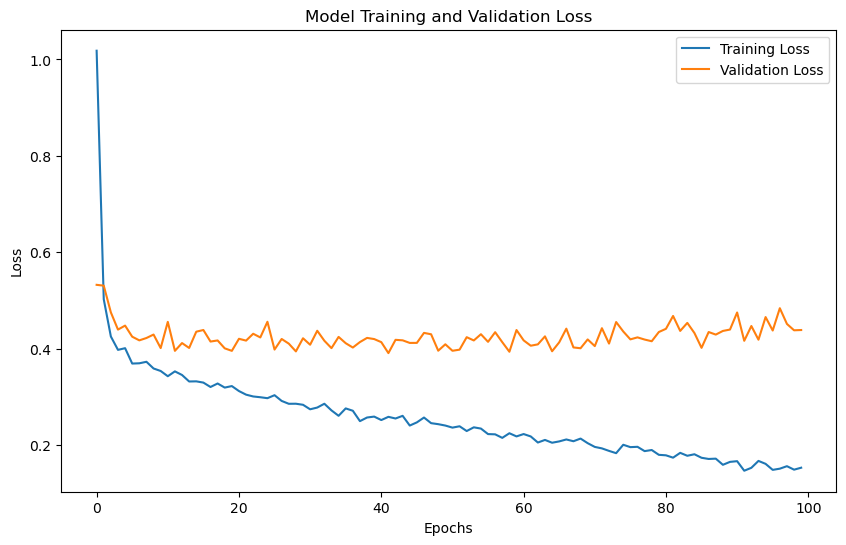

In [47]:
# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [48]:
# Predict
y_pred = model.predict(X_test_scaled)
# Reshaping predictions to match y_test
y_pred = y_pred.flatten()
# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')
# Save the model for future predictions
model.save("game_sales_forecast_model.keras")

12/12 [==============================] - 1s 2ms/step
Mean Squared Error (MSE): 0.43863668588457566
R-squared: 0.18754321603265411
Mean Absolute Error (MAE): 0.4957241214408962


In [49]:

new_game_data = {
    'Platform': ['PS2'],  # Platform of the game
    'Genre': ['Action'],  # Genre of the game
    'Rating': ['T'],  # Rating of the game
    'Critic_Score': [85],  # Critic score
    'Critic_Count': [20],  # Number of critic reviews
    'User_Score': [8.5],  # User score
    'User_Count': [100]  # Number of user reviews
}
new_game_df = pd.DataFrame(new_game_data)

new_game_df2 = pd.get_dummies(new_game_df, columns=['Rating','Genre','Platform'])
#alignment
origional_columns= scaler.feature_names_in_
new_game_df2 = new_game_df2.reindex(columns=origional_columns, fill_value=0)

#scaling
NG_scaled = scaler.transform(new_game_df2)

# Reshape the new data for the LSTM model (samples, time steps, features)
NG_scaled = NG_scaled.reshape((NG_scaled.shape[0], 1, NG_scaled.shape[1]))

In [50]:
from tensorflow.keras.models import load_model
loaded_model = load_model("game_sales_forecast_model.keras")

sales_prediction = loaded_model.predict(NG_scaled)

print(f"Predicted Global Sales for the new game: ${sales_prediction[0][0]:.2f}")

1/1 [==============================] - 1s 758ms/step
Predicted Global Sales for the new game: $1.22
